### Notebook to find variants of a genome mapped on the de Bruijn graph of a RPGG (RR PanGenome Graph)

In [113]:
%matplotlib notebook
import bioinformatics_functions as bio
import gzip
import os
import matplotlib.pyplot as plt
import numpy as np


In [189]:
def read_tr_kmers(file):
    tr_elements = set()
    with open(file, 'r') as tr_elem:
        for line in tr_elem:
            line = line.rsplit()
            if not '>0' in line:
                tr_elements.add(int(line[0]))
    return tr_elements
            
def add_sequence_to_multiplicity_dict(edit_list, multiplicity_dict, read, k, read_index, tr_elements):
#    print(edit_list, len(edit_list))
    n = len(read)
    for i in range(len(edit_list)):
        pos = edit_list[i][0]
        # move through this position along the read
        
        # options:
        # mismatch; letter in the graph is shown. 
        # --> k entries in read are not found in graph
        # deletion; letter in the graph is shown as 0123 for ACGT, respectively
        # --> k-1 entries in read are not found in the graph
        # insertion: can be treated the same way as a mismatch
        # get the sequence from the read:
        
        if (edit_list[i][1] in list('ACTG')):
            max_pos = min(pos+k, n-k+1)         # max starting position in the read
        elif (edit_list[i][1] in list('I')):
            max_pos = min(pos+k, n-k+1)         # max starting position in the read
        elif edit_list[i][1] in list('0123'):
            max_pos = min(pos+k, n-k+1-1)
        else:
            print('An element was found that cannot be treated!!!')
                    
        for j in range( pos,max_pos ):
            if not j in read_index:
                read_index.append(j)

                # get the sequence from the read:
                seq = read[j:j+k]
                # get the reverse compliment
                seqs = [seq, bio.reverse_conjugate(seq)]
                # find the canonical sequence
                seqs.sort()
                # convert canonical sequence to number
                seq_num = bio.pattern_to_number(seqs[0])
                
                # check that the found kmer is not in the tandem repeat graph:
                if not seq_num in tr_elements:
                    # include the canonical sequence in number format to the dictionary
                    if seq_num in multiplicity_dict.keys():
                        multiplicity_dict[seq_num] += 1
                    else:
                        multiplicity_dict[seq_num] = 1    
                        
    return multiplicity_dict
        

def evaluate_ops(read, ops, multiplicity_dict, k, tr_elements):
    n = len(ops)
    region = ''
    edit_list = []    
    for i in range(n):
        read_index = []
        char = ops[i]
        left = ops[max(0,i-1)]     # characters left and right of index i
        right = ops[min(i+1, n-1)]
        
        if char in list('.*'):
            region = 'ignore'
        elif char in list('='):
            region = 'TR'
        elif ops[i] in list('ATCG0123I'):
            # check if if a neighboring edit is either in flank or unassigned
            if left in list('.*') or right in list('.*'):
                edit_list = []   # empty the edit list
                region = 'ignore'
            elif left in list('=') and right in list('='):
                edit_list.append([i,char])
                multiplicity_dict=add_sequence_to_multiplicity_dict(edit_list, multiplicity_dict, read, k, read_index, tr_elements)
            elif left in list('='):
                edit_list.append([i,char])
                region = 'TR'
                if i==n-1:   # last element
                    multiplicity_dict=add_sequence_to_multiplicity_dict(edit_list, multiplicity_dict, read, k, read_index, tr_elements)
                    edit_list = []
            elif right in list('=') and region in ['', 'TR']:
                edit_list.append([i,char])
                multiplicity_dict=add_sequence_to_multiplicity_dict(edit_list, multiplicity_dict, read, k, read_index, tr_elements)
                edit_list = []
            elif left in list('ATCG0123I') and right in list('ATCG0123I') and region in ['','TR']:
                edit_list.append([i,char])
                if i==n-1:   # last element
                    multiplicity_dict=add_sequence_to_multiplicity_dict(edit_list, multiplicity_dict, read, k, read_index, tr_elements)
                    edit_list = []
#        if len(read_index)>0: print(len(read_index))
    return multiplicity_dict
                        


8404


<IPython.core.display.Javascript object>


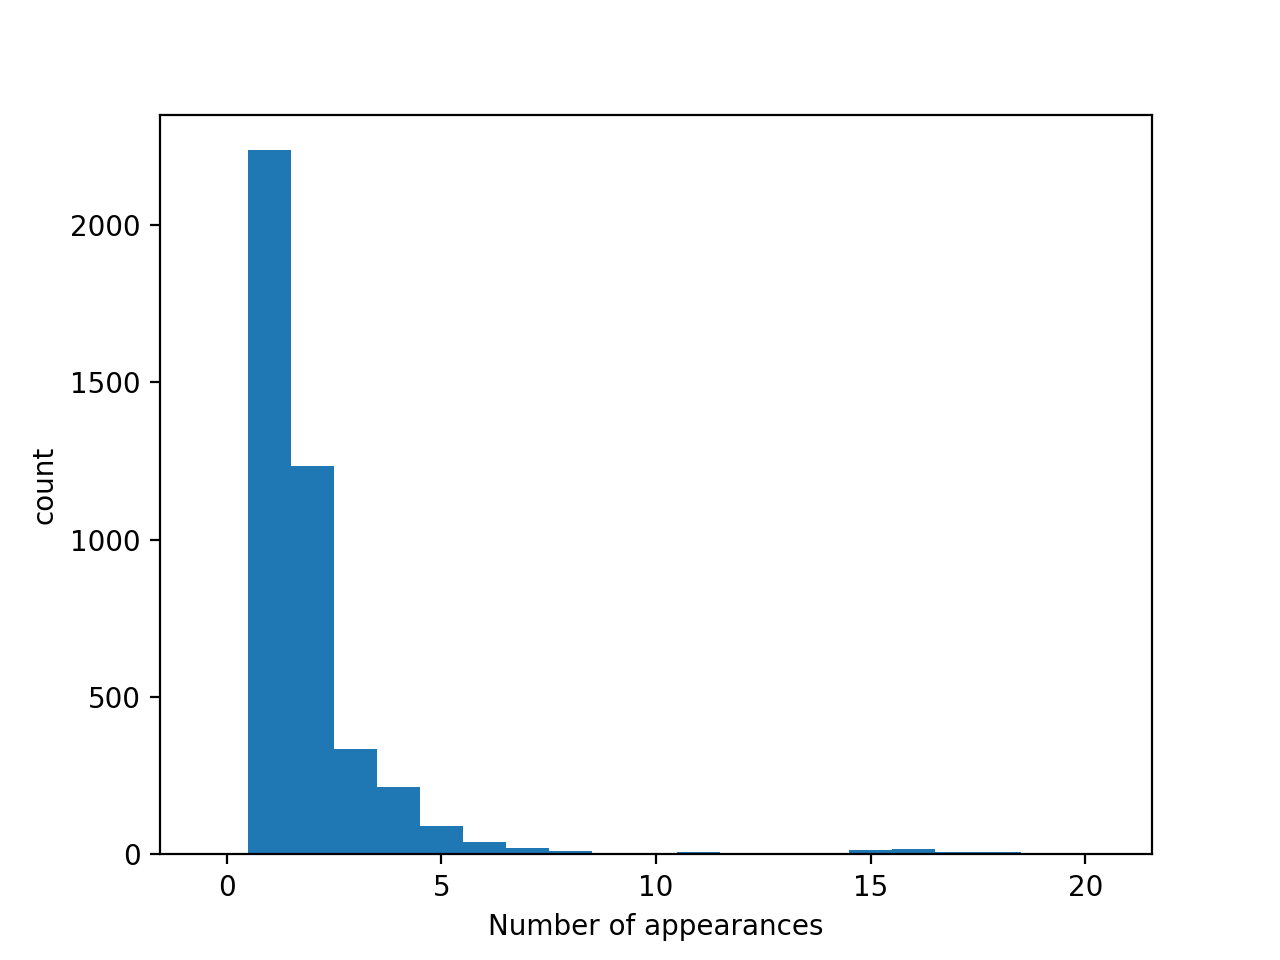

In [192]:
k = 21

# read in the graph from the tandem repeat region:
path = os.path.join("/","Users","tkroll","Dropbox","uni_dropbox","Courses","bioinformatics_USC","rare_variants","rare_var","input")
file = path + "/" + "loo_HG00171.175.tr.kmers"   # HG00171 is the name of the gnome (human gemome 00171)
tr_elements = read_tr_kmers(file)

# read in the result from danbing-tk:
path = os.path.join("/","Users","tkroll","Dropbox","uni_dropbox","Courses","bioinformatics_USC","rare_variants","rare_var","output")
#file = path + "/" + "175.aln.gz"
file = path + "/" + "175.err.1bpindel.aln.gz"

multiplicity_dict = {}
cnt = 0

with gzip.open(file, 'rt') as f:
    for line in f:
        read_forward_strand = line.split()[3]
        ops_forward_strand = line.split()[4]
        read_backward_strand = line.split()[6]
        ops_backward_strand = line.split()[7]
        
        # go through each ops and check if there is an edit, insertion or deletion
        multiplicity_dict=evaluate_ops(read_forward_strand, ops_forward_strand, multiplicity_dict, k, tr_elements)
        multiplicity_dict=evaluate_ops(read_backward_strand, ops_backward_strand, multiplicity_dict, k, tr_elements)

#print(multiplicity_dict)        
#for key in multiplicity_dict.keys():
#    print(key, multiplicity_dict[key], bio.number_to_pattern(key, k))
        
# plot the histogram:

#print(max(list(multiplicity_dict.values())))
#print(list(multiplicity_dict.values()))

print(sum(list(multiplicity_dict.values())))

mylist = list(multiplicity_dict.values())
bins = np.arange(0,max(mylist)+2)-0.5
plt.hist(mylist, bins=bins)
plt.xlabel('Number of appearances')
plt.ylabel('count')
plt.show()        

# check each found kmer if it is already in the graph:
# HG00171 is the name of the gnome (human gemome 00171)
# input/loo_HG00171.175.tr.kmers
# read in as set






In [193]:
#numpy.histogram(a, bins=10, range=None, density=None, weights=None)

mylist = list(multiplicity_dict.values())
hist_ = np.histogram(mylist, bins=bins+0.5)

for i in range(len(hist_[0])):
    print(int(hist_[1][i]), hist_[0][i])


0 0
1 2236
2 1235
3 336
4 214
5 89
6 38
7 20
8 11
9 0
10 1
11 7
12 2
13 0
14 1
15 13
16 16
17 8
18 8
19 3
20 1


yes
